In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:

import os
import json
import pathlib

In [57]:
# where python source code located
import sys
code_path = os.path.abspath("../")

sys.path.append(code_path)

In [58]:
# utility modules or functions

from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser,
)

# WellClass
from src.WellClass.libs.well_class import Well

from src.WellClass.libs.grid_utils import (
    WellDataFrame,
    GridCoarse,
    GridRefine,
    GridLGR,
    LGRBuilder,
)

# plots
from src.WellClass.libs.plotting import (
    plot_grid,
)


In [59]:
!pwd

/scratch/SCS/hzh/SCREEN/notebooks


# Set up case scenario

In [60]:
# root directory for pflotran 
pflotran_working_root = '../test_data/examples/cosmo-pflotran'

In [61]:
# # Examples
cosmo = {
        'well_input': r'cosmo.yaml', 
        # 'well_input': r'cosmo.csv',
        'simcase1': r'TEMP-0_NOSIM',    # for dry run, defined in 'model' folder
        'simcase2': r'TEMP-0',          # for lgr run, defined in 'model' folder
        }

In [62]:
############# 0. User options ######################

# TODO(hzh): use Ali's grid logic
Ali_way = False

# the root path for simulation
sim_path = pathlib.Path(pflotran_working_root)

# configuration filename
well_input = pathlib.Path(cosmo['well_input'])

# dry run: filename prefix on coarse grid, e.g., TEMP-0_NOSIM
sim_case_NOSIM = cosmo['simcase1']

# lgr run: filename prefix on lgr grid, e.g., TEMP-0
sim_case_LGR = cosmo['simcase2']

In [63]:

############# 1. computed parameters ######################

# extract suffix from the configuration file name
file_extension = well_input.suffix

# .yaml or .csv?
use_yaml = False
if file_extension in ['.yaml', '.yml']:
    use_yaml = True


In [64]:

# file prefix for dry run
# where eclipse .EGRID and .INIT files will be located
simcase1 = sim_path/'model'/sim_case_NOSIM
simcase1

PosixPath('../test_data/examples/cosmo-pflotran/model/TEMP-0_NOSIM')

In [65]:
# LGR
simcase2 = sim_path/'model'/sim_case_LGR
simcase2

PosixPath('../test_data/examples/cosmo-pflotran/model/TEMP-0')

# Run coarse simulation

In [66]:
# file name (coarse grid) for pflotran run
run_config_coarse = simcase1.with_suffix('.in')
run_config_coarse

PosixPath('../test_data/examples/cosmo-pflotran/model/TEMP-0_NOSIM.in')

In [67]:
%%bash -s "$run_config_coarse"

runpflotran1.8 -i -nm 6 $1

/scratch/SCS/hzh/SCREEN/test_data/examples/cosmo-pflotran/model /scratch/SCS/hzh/SCREEN/notebooks


 Pflotran 1.8 sv4+
 Pflotran was compiled on: Sep 13 2023 10:24:37            
 RESERVOIR_DEFAULTS option has been selected
 Pflotran card:: DIMENS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: DZ                              
 Pflotran card:: EQUALS                          
 Pflotran card:: COPY                            
 Pflotran card:: MULTIPLY                        
 Pflotran card:: MINPV                           
 Calculating pore volumes
 Calculating connections
 Ncell=       24000  Nact=       24000  Nconn=       69200  Nflt=           0  Npo=           0
 Reading SUBSURFACE cards:
 Pflotran card:: GRID
 Pflotran card:: REFERENCE_PRESSURE
 Pflotran card:: REFERENCE_TEMPERATURE
 Pflotran card:: TIME
 Pflotran card:: OUTPUT
 Pflotran card:: NEWTON_SOLVER
 Pflotran card:: MATERIAL_PROPERTY
   Name :: formation
 "MATERIAL_PROPERTY,rock density units" set to default value.
 "MATERIAL_PROPERTY,specific heat units" set to default valu

/scratch/SCS/hzh/SCREEN/notebooks


# Build LGR

In [68]:
############ 2. Load well configuration file ###############

# where well configuration file is located
well_name = sim_path/well_input

if use_yaml:

        # # pydantic model
        well_model = yaml_parser(well_name)
        well_csv = json.loads(well_model.spec.model_dump_json())
else:

        # load the well information
        well_csv = csv_parser(well_name)

In [69]:
########### 3. build Well class ######################
# build well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
        )
# to well dataframe
well_df = WellDataFrame(my_well)

# for convenience
# extract dataframes
annulus_df = well_df.annulus_df
drilling_df = well_df.drilling_df
casings_df = well_df.casings_df
borehole_df = well_df.borehole_df
barriers_mod_df = well_df.barriers_mod_df


In [70]:

############### 4. various grids #####################

##### 4.1 grid_coarse 
# Loading the model
grid_coarse = GridCoarse(str(simcase1))

grid_coarse.NX, grid_coarse.NY, grid_coarse.NZ

(20, 20, 60)

In [71]:

##### 4.2 LGR grid 
# LGR grid information in x, y, z directions
lgr = LGRBuilder(grid_coarse, 
                annulus_df, 
                drilling_df, casings_df, borehole_df,
                Ali_way)

Minimimum grid size is 5.00 cm


In [72]:
##### 4.3 grid refine 

# Set up dataframe for LGR mesh
grid_refine = GridRefine(grid_coarse,
                        lgr.LGR_sizes_x, lgr.LGR_sizes_y, 
                        lgr.LGR_sizes_z, 
                        )

grid_refine.mesh_df


nx=22, ny=22, nz=150


,i,j,k,DX,DY,DZ,X,Y,Z,Zcorn_top,...,PERMX,PERMY,PERMZ,MULTX,MULTY,MULTZ,MULTX-,MULTY-,MULTZ-,PORO
0,0,0,0,91.731525,91.731525,10.1,45.865763,45.865763,5.050000,0.000000,...,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0,1,0,91.731525,7.289250,10.1,45.865763,95.376150,5.050000,0.000000,...,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0,2,0,91.731525,0.579225,10.1,45.865763,99.310388,5.050000,0.000000,...,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0,3,0,91.731525,0.050000,10.1,45.865763,99.625000,5.050000,0.000000,...,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0,4,0,91.731525,0.050000,10.1,45.865763,99.675000,5.050000,0.000000,...,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72595,21,17,149,91.731525,0.050000,5.0,154.134237,100.325000,2475.501953,2473.001953,...,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2
72596,21,18,149,91.731525,0.050000,5.0,154.134237,100.375000,2475.501953,2473.001953,...,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2
72597,21,19,149,91.731525,0.579225,5.0,154.134237,100.689612,2475.501953,2473.001953,...,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2
72598,21,20,149,91.731525,7.289250,5.0,154.134237,104.623850,2475.501953,2473.001953,...,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2


In [73]:
############### 5. build LGR #####################

##### 5.1 compute bounding box 
# Bounding box for well elements
well_df.compute_bbox(grid_refine.mesh_df, grid_refine.nx)

##### 5.2 set up material type 
# set up material type
grid_refine.set_material_type(drilling_df,
                              casings_df, 
                              barriers_mod_df)

##### 5.3 set up permeability 
# set up permeability
grid_refine.set_permeability(drilling_df, casings_df, barriers_mod_df)

In [74]:
############### 6. output LGR #####################

LGR_NAME = 'TEMP_LGR'
output_dir = sim_path/'include'


# Write LGR file
lgr.build_grdecl(output_dir, LGR_NAME,
                drilling_df,
                casings_df,
                barriers_mod_df)

DEBUG ==============> handling open hole section
DEBUG ==============> handling open hole section
...Prints isolating OVB from reservoir keywords in TEMP_LGR.grdecl file
...Prints CARFIN Keywords in TEMP_LGR.grdecl file
...Prints Casings, cement bonds and barrie(s) in TEMP_LGR.grdecl file
...Prints isolating OVB from reservoir in the LGR in TEMP_LGR.grdecl file
Output LGR CARFIN to:  /scratch/SCS/hzh/SCREEN/test_data/examples/cosmo-pflotran/include/TEMP_LGR.grdecl


# Run LGR simulation

In [75]:
# file name (LGR grid) for pflotran run
run_config_lgr = simcase2.with_suffix('.in')
run_config_lgr

PosixPath('../test_data/examples/cosmo-pflotran/model/TEMP-0.in')

In [76]:
%%bash -s "$run_config_lgr"

runpflotran1.8 -i -nm 6 $1

/scratch/SCS/hzh/SCREEN/test_data/examples/cosmo-pflotran/model /scratch/SCS/hzh/SCREEN/notebooks


 Pflotran 1.8 sv4+
 Pflotran was compiled on: Sep 13 2023 10:24:37            
 RESERVOIR_DEFAULTS option has been selected
 Pflotran card:: DIMENS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: CARFIN                          
 Pflotran card:: NXFIN                           
 Pflotran card:: NYFIN                           
 Pflotran card:: NZFIN                           
 Pflotran card:: HXFIN                           
 Pflotran card:: HYFIN                           
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS                          
 Pflotran card:: EQUALS   

/scratch/SCS/hzh/SCREEN/notebooks


### Load files from pflotran simulation

In [77]:
# load LGR grid from simulation file
grid_lgr = GridLGR(str(simcase2))

In [78]:
# lgr mesh from simulation file
lgr_index = grid_lgr.lgr_index

# Visualization

In [79]:
import inspect
inspect.getfile(plot_grid)

'/scratch/SCS/hzh/SCREEN/src/WellClass/libs/plotting/plot_grids.py'

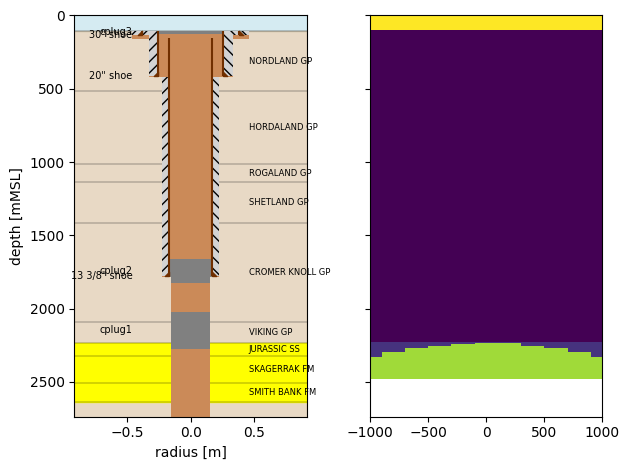

In [80]:
# coarse grid
plot_grid(my_well, grid_coarse, on_coarse=True)


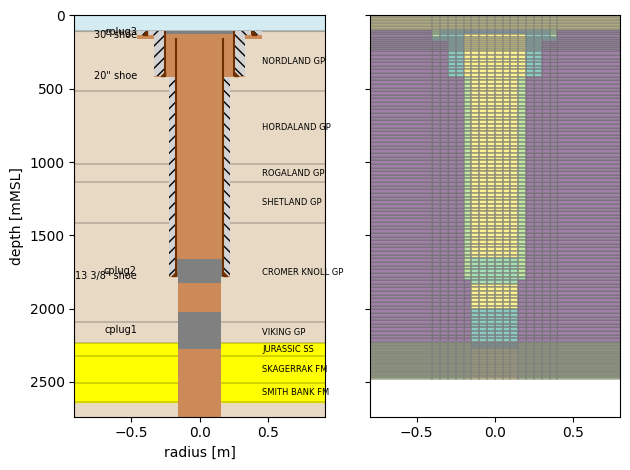

In [81]:
# LGR grid from dataframe
plot_grid(my_well, grid_refine, on_coarse=False)

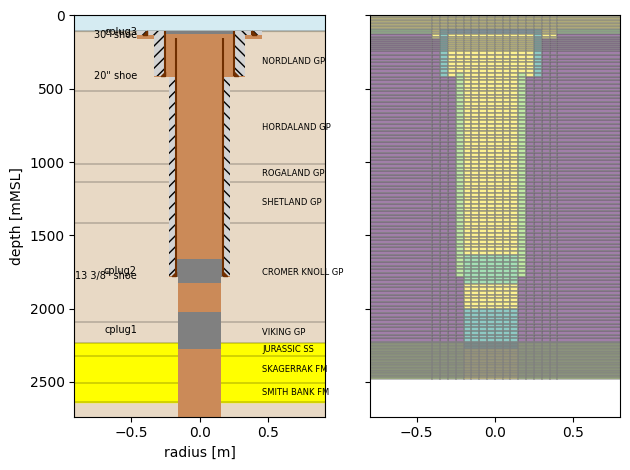

In [82]:
# LGR grid from pflotran output
plot_grid(my_well, grid_lgr, on_coarse=False)

# Other Qcs

In [83]:
ip_grid = grid_refine.mesh_df.sort_values(by=["k","j","i"])
ip_grid

,i,j,k,DX,DY,DZ,X,Y,Z,Zcorn_top,...,PERMY,PERMZ,MULTX,MULTY,MULTZ,MULTX-,MULTY-,MULTZ-,PORO,material
0,0,0,0,91.731525,91.731525,10.1,45.865763,45.865763,5.050000,0.000000,...,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,overburden
22,1,0,0,7.289250,91.731525,10.1,95.376150,45.865763,5.050000,0.000000,...,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,overburden
44,2,0,0,0.579225,91.731525,10.1,99.310388,45.865763,5.050000,0.000000,...,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,overburden
66,3,0,0,0.050000,91.731525,10.1,99.625000,45.865763,5.050000,0.000000,...,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,overburden
88,4,0,0,0.050000,91.731525,10.1,99.675000,45.865763,5.050000,0.000000,...,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,overburden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72511,17,21,149,0.050000,91.731525,5.0,100.325000,154.134237,2475.501953,2473.001953,...,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,overburden
72533,18,21,149,0.050000,91.731525,5.0,100.375000,154.134237,2475.501953,2473.001953,...,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,overburden
72555,19,21,149,0.579225,91.731525,5.0,100.689612,154.134237,2475.501953,2473.001953,...,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,overburden
72577,20,21,149,7.289250,91.731525,5.0,104.623850,154.134237,2475.501953,2473.001953,...,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,overburden


In [84]:
type(ip_grid)

pandas.core.frame.DataFrame

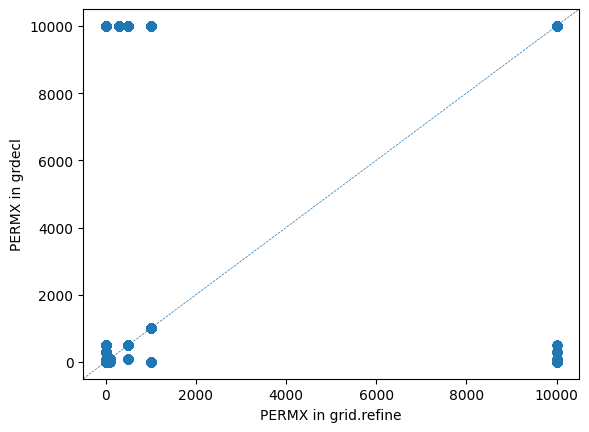

In [85]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
prop = 'PERMX'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')

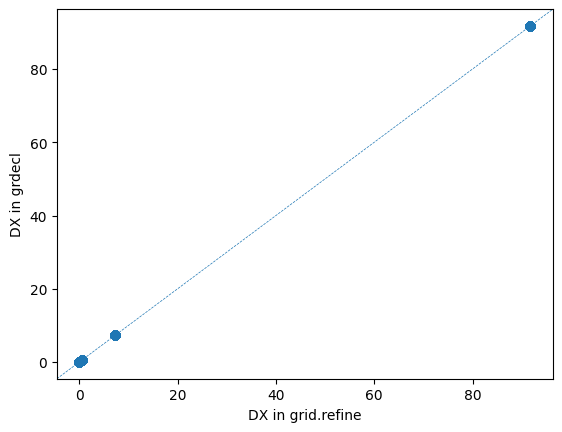

In [86]:
fig, ax = plt.subplots()
prop = 'DX'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')

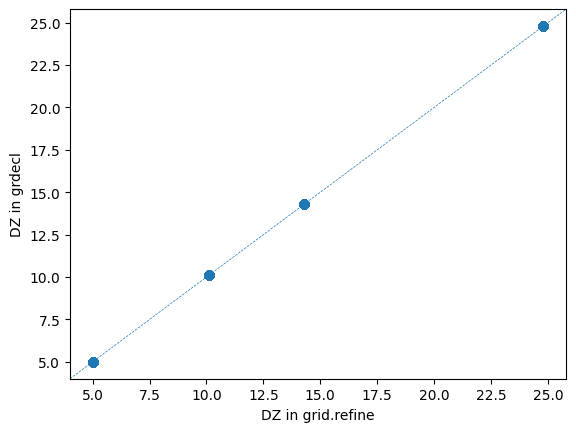

In [87]:
fig, ax = plt.subplots()
prop = 'DZ'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')